In [137]:
from tdavec.TDAvectorizer import *
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [2]:
?createEllipse

Signature: createEllipse(n=100, a=1, b=1, eps=0.1)
Docstring: <no docstring>
File:      ~/Work/STUDY/2024/TDAvec/env/lib/python3.8/site-packages/tdavec/TDAvectorizer.py
Type:      function

In [88]:
np.random.seed(42)
epsList = np.random.uniform(low = 0, high = 1, size = 500)
clouds = [createEllipse(a=1, b=eps, n=100) for eps in epsList]

In [89]:
v = TDAvectorizer()
v.setParams({"scale":np.linspace(0, 2, 30)})
v.fit(clouds)

In [90]:
X = v.transform(output="PS", homDim=1)

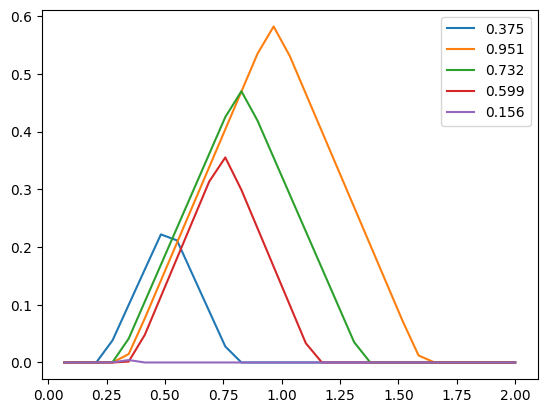

In [91]:
for i, e in enumerate(epsList[:5]):
    plt.plot(v.getParams()["scale"][1:],X[i,:], label=np.round(e, 3))
plt.legend()


In [126]:
methodList = ["vab", "ps", "nl", "ecc", "fda"]

def makeSim(method, homDim, vec = v, y=epsList):
    X =v.transform(output=method, homDim=homDim)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, random_state=42)
    model = LinearRegression().fit(Xtrain, ytrain)
    test_preds = model.predict(Xtest)
    score = model.score(Xtest, ytest)
    res = {"method":method, "homDim":homDim, "test_preds":test_preds, "score":score}
    return res

In [143]:
results = []
df = pd.DataFrame()
for homDim in [0, 1]:
    for method in methodList:
        res = makeSim(method, homDim); results.append(res)
        df = pd.concat([df, pd.DataFrame(res)])
df = df[["method", "homDim", "score"]].drop_duplicates()

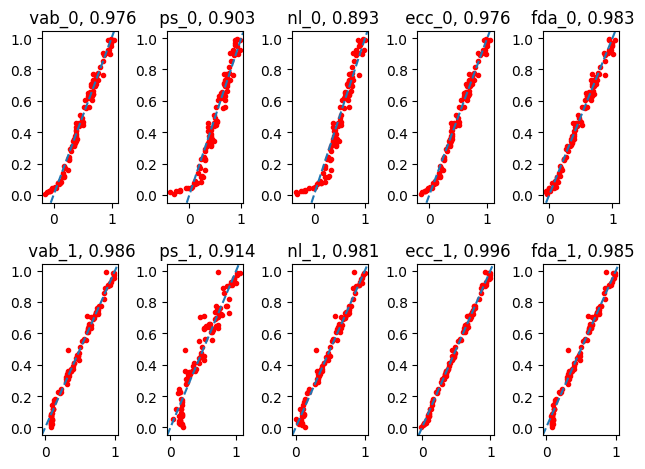

In [144]:
for i, r in enumerate(results):
    plt.subplot(2, 5, i+1)
    plt.plot(r["test_preds"], ytest, "r.")
    plt.axline( (0,0), slope=1, linestyle = "--")
    plt.title(" {}_{}, {:.3f}".format(r["method"], r["homDim"], r["score"]))
plt.tight_layout()

In [145]:
df

,method,homDim,score
0,vab,0,0.976142
0,ps,0,0.903171
0,nl,0,0.893031
0,ecc,0,0.976142
0,fda,0,0.983050
0,vab,1,0.985684
0,ps,1,0.913956
0,nl,1,0.980520
0,ecc,1,0.996198
0,fda,1,0.984793
